# Biodiversity data - Codecademy Portfolio Project

We will be exploring two CSV files:

* species_info.csv - contains data about different species and their conservation status
* observations.csv - holds recorded sightings of different species at several national parks for the past 7 days.

species_info.csv:

* category - class of animal
* scientific_name - the scientific name of each species
* common_name - the common names of each species
* conservation_status - each species’ current conservation status

observations.csv:

* scientific_name - the scientific name of each species
* park_name - Park where species were found
* observations - the number of times each species was observed at park

### Import Python Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tabulate import tabulate

## Data file species_info.csv

### Loading

In [20]:
species_info = pd.read_csv('species_info.csv')
# print(tabulate(species_info.head(), headers='keys', tablefmt='pretty'))
display(species_info.head())
# observations = pd.read_csv('observations.csv')
# observations.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


### Columns data types and counts

In [29]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [46]:
maxRows = species_info['category'].count()
print('Missing Data:')
percent = (1 - species_info.count() / maxRows) * 100
print(percent.apply(lambda x: '{:.2f}%'.format(x)))

Missing Data:
category                0.00%
scientific_name         0.00%
common_names            0.00%
conservation_status    96.72%
dtype: object


### Observations

* The conservation_status column seem to contains mosty NaN values. Only about 3% non-missing values.
* The other three columns do not seem to miss data.

### Categories for the columns

In [32]:
print(species_info.category.value_counts())
print()
print(species_info.scientific_name.value_counts())
print()
print(species_info.common_names.value_counts())
print()
print(species_info.conservation_status.value_counts())


category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64

scientific_name
Procyon lotor             3
Myotis lucifugus          3
Canis lupus               3
Castor canadensis         3
Hypochaeris radicata      3
                         ..
Solanum parishii          1
Solanum xanti             1
Parthenocissus vitacea    1
Vitis californica         1
Saxifraga oregana         1
Name: count, Length: 5541, dtype: int64

common_names
Brachythecium Moss                                                            7
Dicranum Moss                                                                 7
Bryum Moss                                                                    6
Panic Grass                                                                   6
Sphagnum                                                                      6
    

### Observations

* The columns **category** and **conservation_status** contains substantial categories
* About 80% of the "animals" in the dataset are **plants**.
* The columns **scientific_name** and **common_names** contain strings, and are mostly different for each row
* For **conservation_status** 
  * Only about 3% of the data are not missing
  * The values 'Species of Concern', 'Endangered' and 'Threatened' seem to mean the same.  
The fourth value 'In Recovery' seems also to mean 'of concern' but perhaps more specific.

### Missing conservation_status data by species category

Let's see if there is a visible relationship between species category and missing data on conservation status.

Missing conservation_status values by category:
            category  missing_count
0          Amphibian             73
1               Bird            442
2               Fish            116
3             Mammal            176
4  Nonvascular Plant            328
5            Reptile             74
6     Vascular Plant           4424


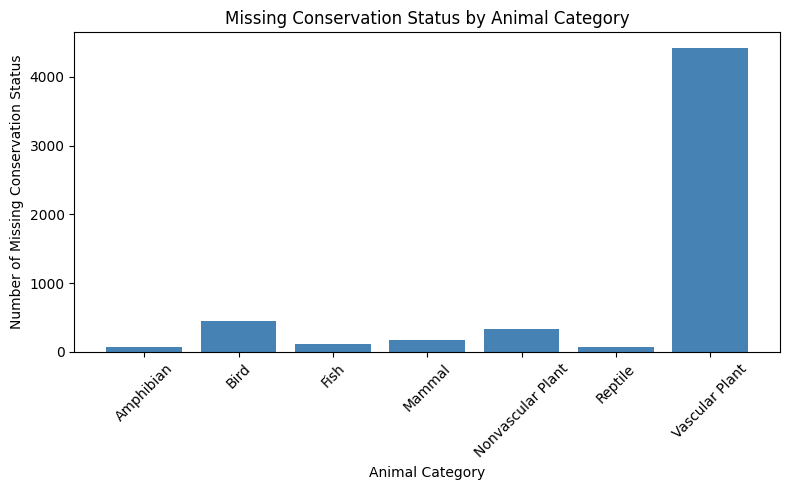

In [47]:
# Group the DataFrame by 'category' and count missing values in 'conservation_status'
missing_counts = (
    species_info.groupby('category')['conservation_status']
      .apply(lambda x: x.isnull().sum())
      .reset_index(name='missing_count')
)

print("Missing conservation_status values by category:")
print(missing_counts)

# Plotting the corresponding bar chart
plt.figure(figsize=(8, 5))
plt.bar(missing_counts['category'], missing_counts['missing_count'], color='steelblue')
plt.xlabel('Animal Category')
plt.ylabel('Number of Missing Conservation Status')
plt.title('Missing Conservation Status by Animal Category')
plt.xticks(rotation=45)  # Rotate category labels if needed for clarity
plt.tight_layout()       # Adjust layout to ensure everything fits without overlapping
plt.show()